# Example: Static inverse free-boundary equilibrium calculations

---

This example notebook shows how to use FreeGSNKE to solve **static inverse** free-boundary Grad-Shafranov (GS) problems. 

In the **inverse** solve mode we seek to estimate the active poloidal field coil currents using user-defined constraints (e.g. on isoflux, x-point, and psi values) and plasma current density profiles for a desired equilibrium shape. 

Note that during this solve, currents are **not** found in any specified passive structures. 

Below, we illustrate how to use the solver for both diverted and limited plasma configurations in a **MAST-U-like tokamak** using stored pickle files containing the machine description. These machine description files partially come from the FreeGS repository and are not an exact replica of MAST-U.

### The static free-boundary Grad-Shafranov problem

Here we will outline the **static free-boundary** GS problem that is solved within both the **forward** and **inverse** solvers, though we encourage you to see [Pentland et al. (2024)](https://arxiv.org/abs/2407.12432) for more details. 

Using a cylindrical coordinate system $(R,\phi,Z)$, the aim is to solve the GS equation:

$$ \Delta^* \psi \equiv \left( \frac{\partial^2}{\partial R^2} - \frac{1}{R} \frac{\partial}{\partial R} + \frac{\partial^2}{\partial Z^2} \right) \psi = -\mu_0 R J_{\phi}(\psi, R, Z), \qquad (R,Z) \in \Omega, $$

for the poloidal flux $\psi(R,Z)$ (which here has units Weber/$2\pi$) in the rectangular computational domain $\Omega$. The flux has contributions from both the plasma and the coils (metals) such that $\psi = \psi_p + \psi_c$. This flux defines the toridal current density $J_{\psi} = J_p(\psi,R,Z) + J_c(R,Z)$, also containing a contribution from both the plasma and coils, respectively. We have the plasma current density (only valid in the core plasma region $\Omega_p$):

$$ J_p(\psi,R,Z) = R \frac{\mathrm{d}p}{\mathrm{d}\psi} +\frac{1}{\mu_0 R} F \frac{\mathrm{d} F}{\mathrm{d} \psi}, \qquad (R,Z) \in \Omega_p, $$

where $p(\psi)$ is the plasma pressure profile and $F(\psi)$ is the toroidal magnetic field profile. The current density generated by the ($N$) active coils and passive structures is given by:

$$ J_c(R,Z) = \sum_{j=1}^{N} \frac{I^c_j(R,Z)}{A_j^c}, \qquad (R,Z) \in \Omega, \quad \text{where} \quad I_j^c(R,Z) = 
\begin{cases} 
    I_j^c & \text{if } (R,Z) \in \Omega_j^c, \\ 
    0 & \text{elsewhere}.
\end{cases}.$$

This makes use of the current $I^c_j$ in each metal and its cross-sectional area $A^c_j$ (the domain of each metal is denoted by $\Omega_j^c$).

To complete the problem, we need the integral (Dirichlet) free-boundary condition:

$$ \psi(R,Z) = \int_{\Omega} G(R,Z;R',Z') J_{\phi}(\psi, R',Z') \ \mathrm{d}R' \mathrm{d}Z', \qquad (R,Z) \in \partial \Omega, $$

where $G$ is the (known) Green's function for the elliptic operator above.

### Import packages
We'll now go through the steps required to solve the **inverse** problem in FreeGSNKE. 

In [1]:
import os
import matplotlib.pyplot as plt
import freegs4e
import numpy as np

### Create the machine object

First, we build the machine object. This is done using the pickle files saved in the "machine_configs/MAST-U" directory. 

FreeGSNKE requires the following environment variables in order to build the machine:
- `ACTIVE_COILS_PATH`
- `PASSIVE_COILS_PATH`
- `WALL_PATH`
- `LIMITER_PATH`
- `PROBE_PATH` (not required here).

In [2]:
# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle"

In [3]:
# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

No probe configuration is provided


Text(10.027777777777777, 0.5, 'Height, $Z$ [m]')

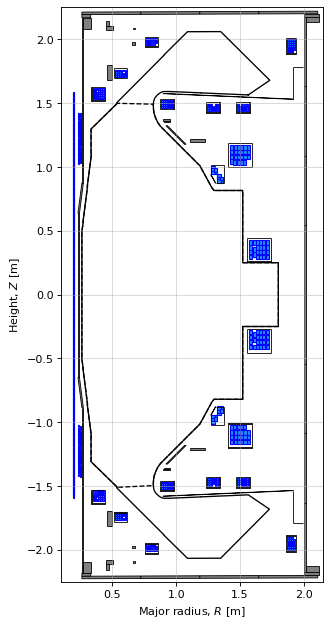

In [4]:
# plot the machine
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
plt.tight_layout()

tokamak.plot(axis=ax1, show=False)
ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")

ax1.grid(alpha=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')

### Instantiate an equilibrium

We are now ready to build a plasma equilibrium object for our tokamak. This is done using the `freegs4e.Equilibrium` class, which implicitly defines the rectangular domain of the solver as well as the grid resolution.

`Equilibrium` has sensible defaults, but it is recommended to define the radial and vertical domain of the grid using the `Rmin`, `Rmax`, `Zmin` and `Zmax` parameters, as well as the grid resolution in the radial and vertical directions with the `nx` and `ny` parameters. The grid will be initialised using fourth-order finite differences. 

A tokamak object should be supplied to the `tokamak` parameter to assign the desired machine to the equilibrium.

If available, an initial plasma flux array (dimensions `nx` x `ny`) can be provided via the `psi` parameter (commented out in the following code). This can be used as an initial guess for the plasma flux $\psi_p$, noting that the total flux is given by $\psi(R,Z) = \psi_p(R,Z) + \psi_c(R,Z)$ where $\psi_c$ is the flux produced by currents in the active coils and passive structures. 

The `eq` object will store a lot of important information and derived quantites once the equilibrium has been calculated (see future notebook on this). 

In [5]:
from freegsnke import equilibrium_update

eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,      # provide tokamak object
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

### Instantiate a profile object

We can now instatiate a profile object that contains the chosen parameterisation of the toroidal plasma current density $J_p$ (i.e. on right hand side of the GS equation). We can then set the paramters for the chosen current density profiles. 

A number of commonly used profile parameterisations exist in FreeGSNKE, including:
- `ConstrainPaxisIp`
- `ConstrainBetapIp`
- `Fiesta_Topeol`
- `Lao85`
- `ProfilesPprimeFfprime`
- `TensionSpline`

In this notebook, we will make use of the `ConstrainPaxisIp` (and `ConstrainBetapIp`) profiles (see [Jeon (2015)](https://link.springer.com/article/10.3938/jkps.67.843)). Others will be utilised in later notebooks. If there is a profile parameterisation you require that does not exist, please do create an issue. 

Both `ConstrainPaxisIp` and `ConstrainBetapIp` are parameterised as follows:
 $$J_{p}(\psi, R, Z) = \lambda\big[ \beta_{0} \frac{R}{R_{0}} \left( 1-\tilde{\psi}^{\alpha_m} \right)^{\alpha_n} + (1-\beta_{0}) \frac{R_0}{R} \left( 1-\tilde{\psi}^{\alpha_m} \right)^{\alpha_n} \big] \quad (R,Z) \in \Omega_p,$$

where the first term is the pressure profile and the second is the toroidal current profile. Here, $\tilde{\psi}$ denotes the normalised flux:
$$ \tilde{\psi} = \frac{\psi - \psi_a}{\psi_b - \psi_a}, $$
where $\psi_a$ and $\psi_b$ are the values of the flux on the magnetic axis and plasma boundary, respectively. 

The parameters required to define the object are:
- `Ip` (total plasma current).
- `fvac` ($rB_{tor}$, vacuum toroidal field strength).
- `alpha_m`>0, and `alpha_n`>0 (that define the shape/peakedness of the profiles).
- If `ConstrainPaxisIp` is used, then `paxis` (pressure on the magnetic axis) is required.
- If `ConstrainBetapIp` is used, then `betap` (proxy of the poloidal beta) is required.


The values of $\lambda$ and $\beta_0$ are found using the above parameters as constraints ($R_0$ is a fixed scaling constant) in the following:

- For `ConstrainPaxisIp`, we can re-arrange the following equations to solve for the unknowns:

$$ p_{\text{axis}} = \lambda \beta_{0} \frac{R}{R_{0}} \int^{\psi_b}_{\psi_a} \left( 1-\tilde{\psi}^{\alpha_m} \right)^{\alpha_n} \mathrm{d} \tilde{\psi} $$

and

$$ I_p = \int^{Z_{\text{max}}}_{Z_{\text{min}}} \int^{R_{\text{max}}}_{R_{\text{min}}} J_p(\psi, R, Z) \ \mathrm{d}R \mathrm{d}Z. $$


- For `ConstrainBetapIp`, we can instead re-arrange and solve the following:

$$ \beta_p = \frac{8 \pi}{\mu_0 I_p^2} \int^{Z_{\text{max}}}_{Z_{\text{min}}} \int^{R_{\text{max}}}_{R_{\text{min}}} p(\psi) \ \mathrm{d}R \mathrm{d}Z. $$

and

$$I_p = \int^{Z_{\text{max}}}_{Z_{\text{min}}} \int^{R_{\text{max}}}_{R_{\text{min}}} J_p(\psi, R, Z) \ \mathrm{d}R \mathrm{d}Z. $$


In what follows, we use `ConstrainPaxisIp`. Note that the equilibrium (`eq`) object is passed to the profile to inform calculations relating to the machine description.

In [6]:
# initialise the profiles
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=8e3,    # profile object
    Ip=6e5,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

### Load the static nonlinear solver

We can now load FreeGSNKE's Grad-Shafranov static solver. The equilibrium is used to inform the solver of the computational domain and of the tokamak properties. The solver below can be used for **both** inverse and forward solves. 

Note: It's not necessary to instantiate a new solver when aiming to use it on new or different equilibria, as long as the integration domain, mesh grid, and tokamak are consistent across solves. 

In [7]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

### Constraints

Recall that in the **inverse** solve mode we seek to **estimate the active poloidal field coil currents** using user-defined **constraints** (e.g. on isoflux, x-point, and psi values) and plasma current density profiles for a desired equilibrium shape. 

FreeGSNKE uses FreeGS4E's `constrain` object, which accepts constraints on:
- the location of any X-points (`xpoints`).
- the locations of pany pairs of points that lie on the same flux surface (`isoflux`). The flux at this pair of locations will be constrained to be the same. 
- the location of any known flux points (`psivals`), i.e. one can specify $\psi$ at any location $(R,Z)$ (not used here). 

At least one constraint (preferably many more) is required to carry out an inverse solve.

Here, we specify two X-point locations (we want a double null plasma) and a around 15 pairs of isoflux locations. The isofluxes here will define the core plasma shape and part of the divertor legs. 

In [8]:
import freegs4e

# set X-point locations
Rx = 0.6
Zx = 1.1
xpoints = [(Rx, -Zx),   
           (Rx,  Zx)]

# set any desired isoflux constraints with format (R1, Z1, R2, Z2), where (R1, Z1) and (R2, Z2) are 
# desired to be on the same flux contour.
Rmid = 1.4    # outboard midplane radius
Rin = 0.35    # inboard midplane radius
isoflux = [(Rx,Zx, Rx,-Zx),     # link X-points
           (Rmid, 0, Rin, 0.0), # link inner and outer midplane points
           (Rmid, 0, Rx, Zx),   # link outer midplane point and X-point

        # additional isoflux constraints
           (Rmid,0, 1.2,.7),
           (Rmid,0, 1.2,-.7),
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),
           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]
           
# instantiate the constrain object
constrain = freegs4e.control.constrain(xpoints=xpoints,
                                         isoflux=isoflux,
                                       # psivals=psivals, # not used
                                         gamma=5e-7       # regularisation factor
                                         )

Given that there may be more or less constraints than unknown parameters (i.e. coil currents), the inverse problem may be over- or under-constrained. This means that there may be zero, one, or many solutions to the problem. 

To combat this, a quadratic (i.e.Tikhonov) regularization parameter `gamma` is specified. Larger values of `gamma` encourage lower absolute coil current values. It is sometimes useful to experiment with different values of `gamma` to explore whether the converged solution departs from the desired constraints. 

### The linear system of constraints

During an inverse solve, a minmisation problem involving the responses, changes in coil currents, and constraints, is repeatedly solved:

$$ \min_{x} \| A\vec{x} - \vec{b}\|^2 + \| \gamma \vec{x} \|^2, $$

where
- $A$: the fixed response matrix (that determines how a change in coil currents $x$, affects constraint values). 
- $\vec{x} = \Delta \vec{I}^c$: the step change in the active coil currents required to match the constraints. 
- $\vec{b}$: the vector of constraint values that we need. 
- $\gamma > 0$: the regularisation parameter.

The solution to this problem can be found by solving the linear system:

$$ (A^T A + \gamma^2 I)\vec{x} = A^T \vec{b}, $$

noting here that $I$ denotes the identity matrix, not the currents. 

[Song et al. (2024)](https://www.mdpi.com/2571-6182/7/4/45) provide a nice overview of the inverse problem.


### Fixed coil currents

It is also possible to set values for the current in specific active poloidal field coils. The inverse solver will not allow the current in these coils to vary if the `control` parameter is set to `False` (i.e. it will exclude them from the linear system above). 

Note: any passive structures in the tokamak automatically have their control parameter set to False and are therefore not included in an inverse solve. 

As an example, we will fix the `Solenoid` current to 5000 Amps and seek a solution in which this value is fixed, rather than estimated by the inverse solve.

In [9]:
eq.tokamak['Solenoid'].current = 5000
eq.tokamak['Solenoid'].control = False  # ensures the current in the Solenoid is fixed

### The inverse solve

The following cell will execute the solve. Since a `constrain` object is provided, this is interpreted as a call to the inverse solver, if `constrain=None`, then the forward solver will be called (see next notebook). The 'target_relative_tolerance' is the maximum relative error on the plasma flux function allowed for convergence and `verbose=True` will provide an indication of the progression of the solve. 

The `picard=False` parameter tells the solver whether to use Picard or Newton-Krylov (NK) iterations to solve the GS equation. 

The solver steps are (roughly):
1. Solve the linear system to find initial coil currents that approximately satisfy the constraints for the initial equilibrium. 
2. While tolerance is not met:
 - use the coil currents to solve the forward GS problem (with Picard or NK iterations).
 - solve the linear system to update coil currents to satisfy constraints for current equilibrium (from forward solve). 
 - check tolerance. 

In [10]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     verbose=True, # print output
                     picard=False, # tells solver to use Newton-Krylov iterations (instead of Picard)
                     )

-----
Newton-Krylov iteration: 0
...relative error =  0.0135243935195993
-----
Newton-Krylov iteration: 1
...relative error =  0.0006405296390940129
-----
Newton-Krylov iteration: 2
...relative error =  0.0006280782580453453
-----
Newton-Krylov iteration: 3
...relative error =  0.000285926453853536
-----
Newton-Krylov iteration: 4
...relative error =  6.846717117997076e-05
-----
Newton-Krylov iteration: 5
...relative error =  2.8173979871973857e-05
-----
Newton-Krylov iteration: 6
...relative error =  2.54989836318452e-06
-----
Newton-Krylov iteration: 7
...relative error =  2.761855392693994e-06
-----
Newton-Krylov iteration: 8
...relative error =  1.0814514557004792e-06
-----
Newton-Krylov iteration: 9
...relative error =  1.0156794279595696e-06
-----
Newton-Krylov iteration: 10
...relative error =  3.0463340512855034e-07


The following plots show how to display:
1. the tokamak with:
   - active coil filaments (rectangles with blue interior)
   - passive structures (blue circles if defined as filaments or thin black outline/grey interior if defined as parallelograms)
   - limiter/wall (solid black)
2. the tokamak + the equilibrium with:
   - separatrix/last closed flux surface (solid red lines)
   - poloidal flux (yellow/green/blue contours, colours indicates magnitude)
   - X-points (red circles)
   - O-points (green crosses)
3. the tokamak + the equilibrum + the contraints with:
   - X-point constraints (blue crosses)
   - isoflux contour constraints (blue triangles, with dashed blue lines)

Note: Setting 'show=True' can toggle the legend on/off.

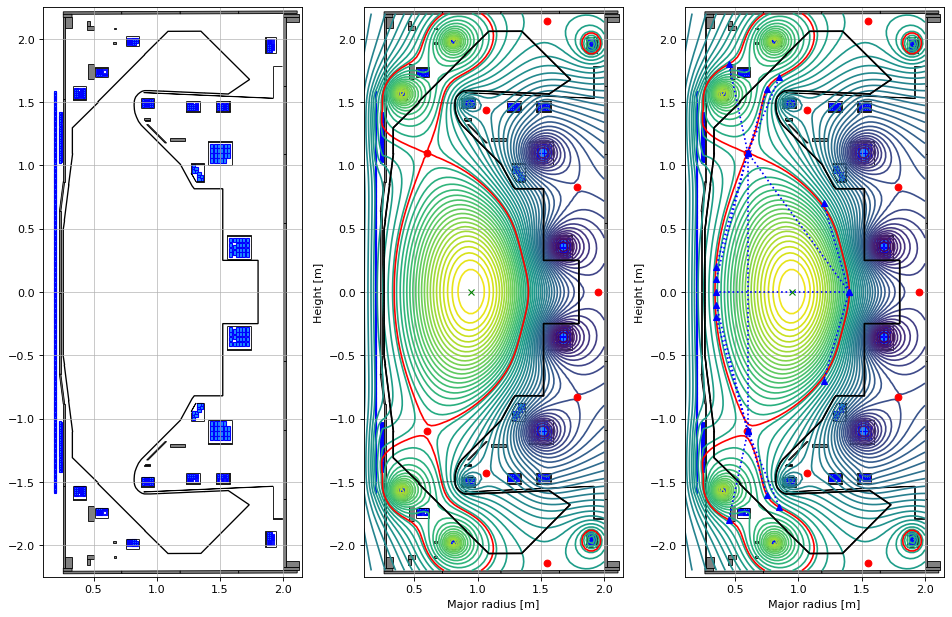

In [11]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8), dpi=80)

ax1.grid(zorder=0, alpha=0.75)
ax1.set_aspect('equal')
eq.tokamak.plot(axis=ax1,show=False)                                                          # plots the active coils and passive structures
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)

ax2.grid(zorder=0, alpha=0.75)
ax2.set_aspect('equal')
eq.tokamak.plot(axis=ax2,show=False)                                                          # plots the active coils and passive structures
ax2.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax2,show=False)                                                                  # plots the equilibrium
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)


ax3.grid(zorder=0, alpha=0.75)
ax3.set_aspect('equal')
eq.tokamak.plot(axis=ax3,show=False)                                                          # plots the active coils and passive structures
ax3.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax3,show=False)                                                                  # plots the equilibrium
constrain.plot(axis=ax3, show=False)                                                          # plots the contraints
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)

plt.tight_layout()

A solve call will modify the equilibrium object in place. That means that certain quantities within the object will be updated as a result of the solve. 

Various different quantities and functions can be accessed via the 'eq' and 'profile' objects. For example:
- the total flux can be accessed with `eq.psi()`.
- the plasma flux with `eq.plasma_psi`.
- the active coil + passive structure flux with `eq.tokamak.psi(eq.R, eq.Z)`.
- (Total flux = plasma flux + coil flux)

Explore `eq.` to see more (also `profiles.`, e.g. the plasma current distribution over the domain can be found with `profiles.jtor`).

The set of optimised coil currents can be retrieved using `eq.tokamak.getCurrents()` having been assigned to the equilibrium object during the inverse solve.

The following lines will save the calculated currents to a pickle file (we will use these in future notebooks). 

In [12]:
inverse_current_values = eq.tokamak.getCurrents()

# save coil currents to file
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=inverse_current_values, file=f)

### Second inverse solve: limited plasma example

Below we carry out an inverse solve seeking coil current values for a limited plasma configuration (rather than a diverted one). 

In a limiter configuration the plasma "touches" the limiter of the tokamak and is confined by the solid structures of the vessel. The last closed flux surface (LCFS) is the closed contour that is furthest from the magnetic axis that just barely touches (and is tangent to) the limiter.

Rather than instantiating a new equilibrium we can use the one above. We also use the same profile object, but illustrate how to vary the total plasma current and pressure on axis within it. 

In [13]:
# first we specify some alterantive constraints
Rmid = 1.4   # outboard midplane radius
Rin = 0.24   # inboard midplane radius

# locations of X-points
Rx = 0.45
Zx = 1.18
xpoints = [(Rx, -Zx),   
           (Rx,  Zx)]

# isoflux constraints
isoflux = [
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),
           (Rmid,0, 1.2,.7),
           (Rmid,0, 1.2,-.7),
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),
           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]

# let's seek an up-down symmetric equilibrium by imposing the current in P6 is zero
#eq.tokamak['P6'].current = 0
#eq.tokamak['P6'].control = False # fixes the current

# let's assume we're also seeking an equilibrium with no solenoid current
eq.tokamak['Solenoid'].current = 0
eq.tokamak['Solenoid'].control = False # fixes the current

# pass the magnetic constraints to a new constrain object
constrain = freegs4e.control.constrain(xpoints=xpoints,
                                         isoflux=isoflux,
                                         gamma=5e-6,
                                        )

# modify the total plasma current
profiles.Ip = 4e5

# modify the pressure on the magnetic axis
profiles.paxis = 6e3

# carry out the inverse solve (which finds the coil currents)
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-3)

# # one can also carry out a forward solve to obtain a "more converged" equilibrium
# GSStaticSolver.solve(eq=eq, 
#                      profiles=profiles, 
#                      constrain=None, 
#                      target_relative_tolerance=1e-9)

In [14]:
# save the currents for later use
inverse_current_values = eq.tokamak.getCurrents()

# save coil currents to file
with open('simple_limited_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=inverse_current_values, file=f)

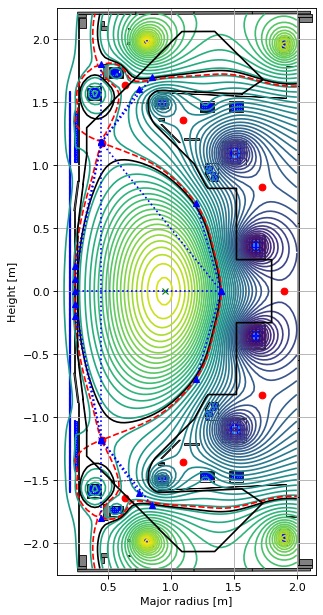

In [15]:
# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
constrain.plot(axis=ax1,show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

Now, let's assume we wish to set the solenoid current to 40000 Amperes. It is advisable to do so in stages as this is easier for the inverse solver to handle while avoiding non-recoverable configurations. 

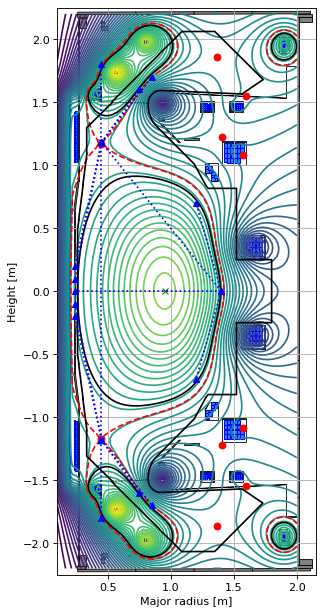

In [16]:
# we first raise the solenoid current to some intermediate value
# Note that `eq.tokamak['Solenoid'].control = False` is still set from above so we don't need it again
eq.tokamak['Solenoid'].current = 10000

# carry out a first inverse solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-3,
                     picard=True,
                     verbose=False
)

# raise the solenoid current further
eq.tokamak['Solenoid'].current = 40000

# carry out another inverse solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-3,
                     picard=True,
                     verbose=False
                     )

# # can do a forward solve here if you wish
# GSStaticSolver.solve(eq=eq, 
#                      profiles=profiles, 
#                      constrain=None, 
#                      target_relative_tolerance=1e-9)

# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
constrain.plot(axis=ax1,show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()